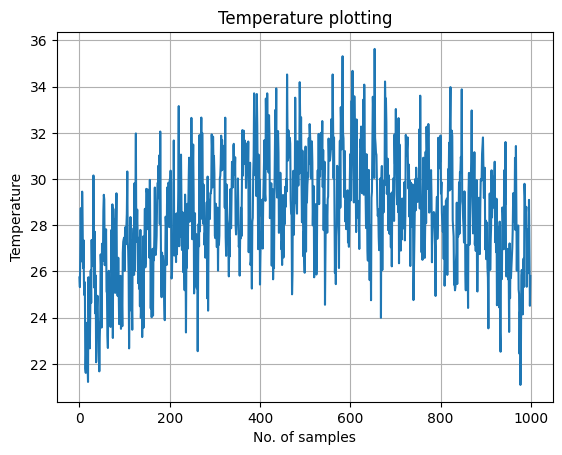

Number of samples in the temperature data:  20000
No of days:  833.3333333333334
The max temperature is:  15843
The min temperature is:  8200


In [ ]:
#2.1 Data Loading

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, freqz
import pandas as pd
import time

# Load the noisy temperature data from CSV
df = pd.read_csv("/content/noisy_temperature_data.csv")
noisy_temperature_data = df["Noisy_Temperature"].values
Fs = 1 # Sampling rate is 1 sample per hour, from data generation
total_samples = len(noisy_temperature_data)

plt.plot(np.arange(1000),noisy_temperature_data[:1000])
plt.xlabel("No. of samples")
plt.ylabel("Temperature")
plt.title("Temperature plotting")
plt.grid()
plt.show()

#PTQ_2
print("Number of samples in the temperature data: ",total_samples)

time_hours = df["Time_Hours"].values
time_end = len(time_hours)
print("No of days: ",time_end/24)

#PTQ_3
print("The max temperature is: ", np.argmax(noisy_temperature_data))
print("The min temperature is: ", np.argmin(noisy_temperature_data))

Designed FIR filter of length M = 101


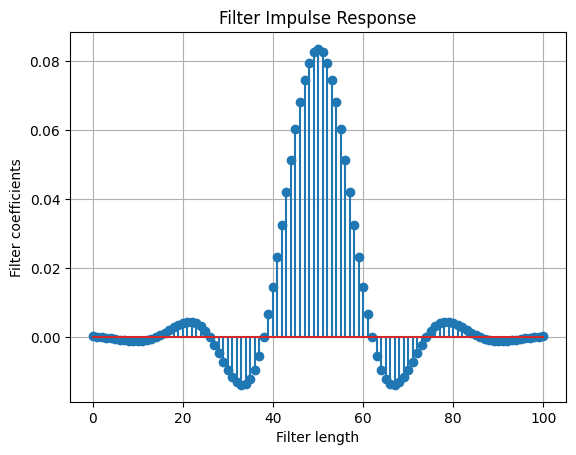

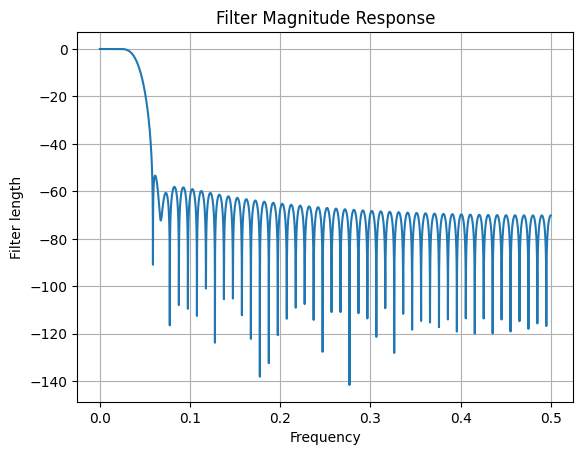

From the magnitude response, the designed filter is a: LOW PASS FILTER
The 3dB cut-off frequency of the filter is 0.0377197265625


In [ ]:
#2.2.1 Filter Design

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, freqz
import pandas as pd
import time

# Load the noisy temperature data from CSV
df = pd.read_csv("noisy_temperature_data.csv")
noisy_temperature_data = df["Noisy_Temperature"].values
Fs = 1 # Sampling rate is 1 sample per hour, from data generation
total_samples = len(noisy_temperature_data)

filter_order = 100 # M-1
cutoff_freq_norm = 1 / (2 * 24) / (Fs / 2)

# h - filter coefficients (or impulse repsonse of the filter)
h = firwin(filter_order + 1, cutoff_freq_norm, pass_zero=True, fs=Fs)
M = len(h) # Actual filter length
print(f"Designed FIR filter of length M = {M}")

plt.stem(np.arange(M),h)
plt.title("Filter Impulse Response")
plt.ylabel("Filter coefficients")
plt.xlabel("Filter length")
plt.grid()
plt.show()


#2.2.2 Frequency Response of Filter
w, H = freqz(h, worN=8192, fs=Fs) # worN is number of points, fs is sample rate
plt.plot(w,20*np.log10(abs(H)))
plt.title("Filter Magnitude Response")
plt.xlabel("Frequency")
plt.ylabel("Filter length")
plt.grid()
plt.show()

#PTQ_6
print("From the magnitude response, the designed filter is a: LOW PASS FILTER")

#PTQ_7
find_3dB= np.where(20*np.log10(abs(H))<= -3)[0][0]
cutoff= w[find_3dB]
print("The 3dB cut-off frequency of the filter is", cutoff)



In [ ]:

L = 1024 # Input block length (adjust for performance, e.g., 2^N)
M = len(h) # Length of the filter impulse response
N_linear_conv = L + M - 1 # FFT length for linear convolution output
# Ensure P is a power of 2 for faster FFT
P = int(2**np.ceil(np.log2(N_linear_conv)))

print(f"L: {L}")
print(f"N (FFT length for linear convolution output): {N_linear_conv}")
print(f"M (Filter length): {M}")
print(f"P (FFT length for block convolution): {P}")


# Pre-compute DFT of filter impulse response (padded to P)
H_fft = np.fft.fft(h, P)
# Initialize output array
filtered_ola_output = np.zeros(len(noisy_temperature_data) + M - 1) # Initialize final output array with zeros. What should be the size of this array?

L: 1024
N (FFT length for linear convolution output): 1124
M (Filter length): 101
P (FFT length for block convolution): 2048


The time of execution of overlap add is: 0.006133556365966797 seconds


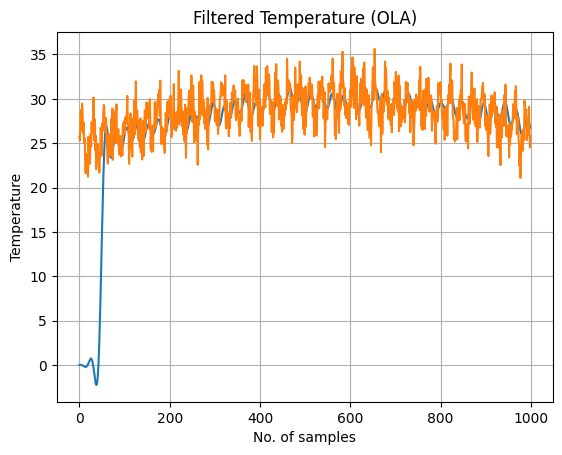

In [ ]:
#2.3.2 Implement Overlap-Add (OLA)

def overlap_add(x, h_fft, L, P):

    M = len(h_fft)
    N = len(x)
    y_ola = np.zeros(N + M - 1)
    num_blocks = int(np.ceil(N / L))

    start_time = time.time()

    for i in range(num_blocks):
        # Define the start and end indices for the current input block
        start = i * L
        end = min(start + L, N)
        block = x[start:end]


        block_padded = np.zeros(P)
        block_padded[:len(block)] = block


        X_block = np.fft.fft(block_padded)


        Y_block = X_block * h_fft


        y_block = np.real(np.fft.ifft(Y_block))


        y_ola[start : start + L] += y_block[0 : L]


        overlap_start_y_ola = start + L
        overlap_length = P - L # The length of the overlap is P - L
        overlap_end_y_ola = min(overlap_start_y_ola + overlap_length, len(y_ola))

        overlap_start_y_block = L
        overlap_end_y_block = L + (overlap_end_y_ola - overlap_start_y_ola) # Ensure the slice length matches

        if overlap_start_y_ola < len(y_ola) and (overlap_end_y_ola - overlap_start_y_ola) > 0:
             y_ola[overlap_start_y_ola : overlap_end_y_ola] += y_block[overlap_start_y_block : overlap_end_y_block]


    end_time = time.time()
    return y_ola, (end_time - start_time)

# Apply the Overlap-Add method to the noisy temperature data
filtered_ola_output, ola_execution_time = overlap_add(noisy_temperature_data, H_fft, L, P)


print(f"The time of execution of overlap add is: {ola_execution_time} seconds")

plt.plot(filtered_ola_output[:1000])
plt.plot(np.arange(1000),noisy_temperature_data[:1000])
plt.xlabel("No. of samples")
plt.ylabel("Temperature")
plt.title("Filtered Temperature (OLA)")
plt.grid()
plt.show()

L = 1024, N = 1124, M = 101, P = 2048, L_ols_valid = 1948
OLS Execution Time: 0.0036 seconds


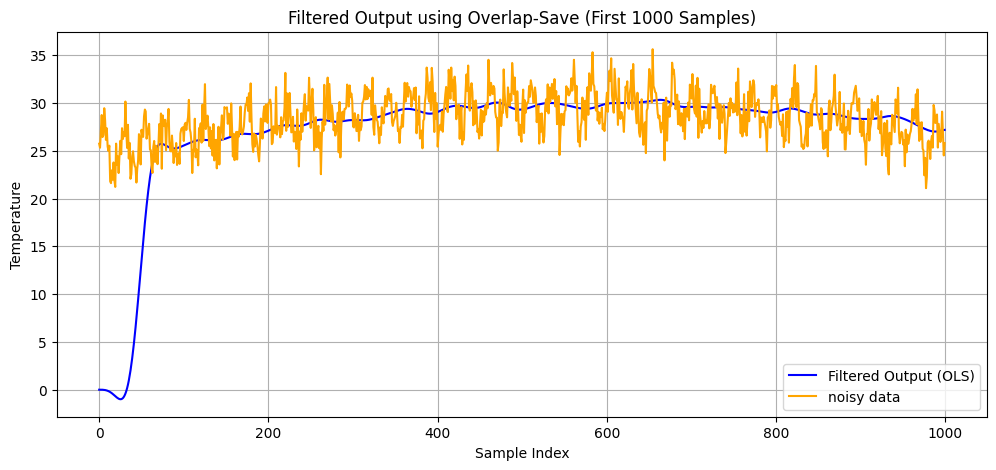

In [ ]:

Nx = len(noisy_temperature_data)

# FIR Filter Design
Fs = 1
filter_order = 100
M = filter_order + 1
cutoff_frequency_hz = 1 / 48
h = firwin(numtaps=M, cutoff=cutoff_frequency_hz, pass_zero=True, fs=Fs)

# FFT Parameters
L = 1024
N = L + M - 1
P = int(2 ** np.ceil(np.log2(N)))
L_ols_valid = P - (M - 1)
print(f"L = {L}, N = {N}, M = {M}, P = {P}, L_ols_valid = {L_ols_valid}")

# OLS Filtering
H_fft_ols = np.fft.fft(h, P)
filtered_ols_output = np.zeros(Nx + M - 1)
overlap_buffer = np.zeros(M - 1)
Nblocks_ols = int(np.ceil(Nx / L_ols_valid))

start_time_ols = time.time()

for i in range(Nblocks_ols):
    start_idx_new = i * L_ols_valid
    end_idx_new = min(start_idx_new + L_ols_valid, Nx)
    current_samples = noisy_temperature_data[start_idx_new:end_idx_new]
    x_block_ols = np.concatenate((overlap_buffer, current_samples))
    if len(x_block_ols) < P:
        x_block_ols = np.pad(x_block_ols, (0, P - len(x_block_ols)), mode='constant')
    X_block = np.fft.fft(x_block_ols)
    Y_block = X_block * H_fft_ols
    y_circular = np.real(np.fft.ifft(Y_block))
    valid_output = y_circular[M - 1:M - 1 + (end_idx_new - start_idx_new)]
    output_start_idx = start_idx_new
    filtered_ols_output[output_start_idx:output_start_idx + len(valid_output)] = valid_output
    overlap_buffer = x_block_ols[P - (M - 1):P]

end_time_ols = time.time()
print(f"OLS Execution Time: {end_time_ols - start_time_ols:.4f} seconds")

# Plot OLS Output
plt.figure(figsize=(12, 5))
plt.plot(filtered_ols_output[:1000], label='Filtered Output (OLS)', color='blue')
plt.plot(noisy_temperature_data[:1000],label='noisy data', color= 'orange')
plt.title('Filtered Output using Overlap-Save (First 1000 Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def linear_convolution(x,h):
  N = len(x)
  M = len(h)
  y=np.zeros(N+M-1)
  start_time = time.time() # Start time for linear convolution
  for i in range(N):
    for j in range(M):
      y[i+j] += x[i]*h[j]
  end_time = time.time() # End time for linear convolution
  execution_time = end_time - start_time
  return y, execution_time


system_out_linear_conv, linear_conv_execution_time = linear_convolution(noisy_temperature_data, h)

min_len = min(len(system_out_linear_conv), len(filtered_ols_output), len(filtered_ola_output))

# Calculate errors
error_ols= np.mean(np.abs((system_out_linear_conv[:min_len]-filtered_ols_output[:min_len])**2))
error_ola= np.mean(np.abs((system_out_linear_conv[:min_len]-filtered_ola_output[:min_len])**2))
print("Error OLS:", error_ols)
print("Error OLA:", error_ola)
print(linear_conv_execution_time)

Error OLS: 1.862087757419447
Error OLA: 0.6269961360393137
1.193479061126709
